# Staff Graded K-Means and Spectral Clustering

### Part (a)

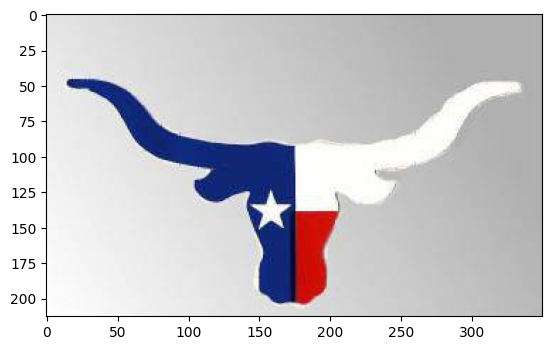

In [20]:
#Load libraries
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from scipy.sparse import diags
from scipy import sparse as sp
import pickle
import math

# Read Images
pkl_file = open('ImageSegmentation.pkl', 'rb')
img = pickle.load(pkl_file)
pkl_file.close()

###############################################################################
# Parts a and b
plt.imshow(img)

### Part (b)

In [21]:
print(img.shape)

(213, 350, 3)


The image appears to be 213 pixels tall, 350 pixels wide, and 3 layers deep.

### Part (c)

In [22]:
###############################################################################
# Setup for part c and beyond
I = img.shape[0]
J = img.shape[1]
numPixels = I * J

redPixelVals = img[:,:,0].flatten()
greenPixelVals = img[:,:,1].flatten()
bluePixelVals = img[:,:,2].flatten()
###############################################################################
# Part c
#Create Queens Neighbor Matrix
#CSR Sparse Initialization
neighborMat = csr_matrix((numPixels,numPixels))

#By Definition, the neighbors of a pixel are the following pixels
adjToNeighbor = np.array([1,J-1,J,J+1,-1,-(J-1),-J,-(J+1)])
neighborGrid = np.array([x + adjToNeighbor for x in range(numPixels)])

#Now we need to adjust the matrix to remove issues at the boundaries
rowNums = np.asarray(np.repeat(list(range(numPixels)),8)).reshape([numPixels,8])
neighborGrid[neighborGrid < 0] = rowNums[neighborGrid < 0]
neighborGrid[neighborGrid > numPixels-1] = rowNums[neighborGrid > numPixels-1]
neighborGrid[J * np.array(range(I)),1] = J * np.array(range(I))
neighborGrid[J * np.array(range(I)),4] = J * np.array(range(I))
neighborGrid[J * np.array(range(I)),7] = J * np.array(range(I))
neighborGrid[J * np.array(range(1,I+1))-1,5] = J * np.array(range(1,I+1))-1
neighborGrid[J * np.array(range(1,I+1))-1,3] = J * np.array(range(1,I+1))-1
neighborGrid[J * np.array(range(1,I+1))-1,0] = J * np.array(range(1,I+1))-1

#Is there a more direct way of doing all this? Probably. But this all works
neighborMat[np.repeat(list(range(numPixels)),8),neighborGrid.flatten()] = 1
neighborMat[np.array(range(numPixels)),np.array(range(numPixels))] = 0

#Find neighbors of pixel 73850
target = 73850
print(f'Target pixel is on row index {target // img.shape[0] - 1}, column index {target % img.shape[0] - 1}\n')

# Pull row corresponding to pixel of interest and show values
full_row = neighborMat.getrow(target)
print(f'Table of pixels adjacent to 73850:\n{full_row}')

/Users/reese/PycharmProjects/Advanced_Predictive_Models/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Target pixel is on row index 345, column index 151

Table of pixels adjacent to 73850:
  (0, 73500)	1.0
  (0, 73501)	1.0
  (0, 73850)	0.0
  (0, 73851)	1.0
  (0, 74200)	1.0
  (0, 74201)	1.0


From the table produced from the code above, we can see that the pixels adjacent to pixel 7850 are pixels 73500, 73501, 73851, 74200, 74201.

### Part (d)

In [23]:
#Part d
#Now lets find which spots we need to calculate things for the W matrix
ixW = sp.find(neighborMat == 1)

#Initialzie W matrix and set sigma parameter
s = 30  # This is sigma, not squared
W = csr_matrix((numPixels,numPixels))

#Calculate the W Matrix
rgb = np.stack((redPixelVals, greenPixelVals, bluePixelVals)).T
diff = rgb[ixW[0], :] - rgb[ixW[1], :]
W[ixW[0], ixW[1]] = np.exp(-np.sum(np.square(diff), axis=1) / (2*s**2))

#Calculate the D Matrix
D = np.squeeze(np.asarray(np.sum(W,axis = 1)))       

#Check the values of the D matrix
print(f'Max value in D:\n{D.max()}')
print('\n')
print(f'Min value in D:\n{D.min()}')
print('\n\n')

#Report values of D matrix
print(f'Value of D[0,0]:\n{"{:.3f}".format(round(D[0],3))}\n')
print(f'Value of D[612,612]:\n{"{:.3f}".format(round(D[612],3))}\n')
print(f'Value of D[72630,72630]:\n{"{:.3f}".format(round(D[72630],3))}')

Max value in D:
8.0


Min value in D:
0.00015761396890586016



Value of D[0,0]:
3.000

Value of D[612,612]:
7.998

Value of D[72630,72630]:
5.450


### Part (e)

In [24]:
#Part e
#Create the L matrix and LSM matrix
D_sparse = sp.diags(D)
L = D_sparse - W
Lrw = sp.diags(1/D) @ L


#Part e answers
print(f'Number of nonzero elements in Lsm: {np.sum(Lrw != 0)}\n')
print(f'Value of Lsm[55,62]: {"{:.3f}".format(round(Lrw[55,62],3))}\n')
print(f'Value of Lsm[34331,34332]: {"{:.3f}".format(round(Lrw[34331,34332],3))}\n')
print(f'Value of Lsm[74199,74548]: {"{:.3f}".format(round(Lrw[74199,74548],3))}')

Number of nonzero elements in Lsm: 667576

Value of Lsm[55,62]: 0.000

Value of Lsm[34331,34332]: -0.124

Value of Lsm[74199,74548]: -0.192


### Part (f)

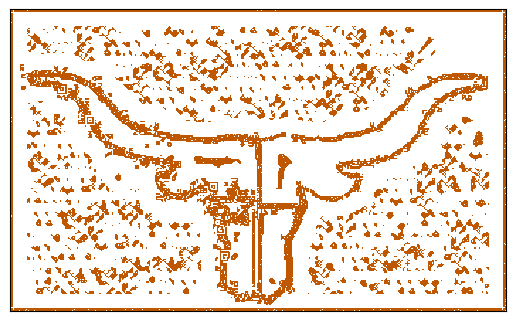

In [25]:
#Part f
#Find the eigenvectors (and values) of the L matrix
K = 10
M = csr_matrix(diags(D))
Minv = csr_matrix(diags(1/D))
initVec = (D > 6)
#Other options for initVec that yield different results
# initVec = (redPixelVals > 100)/numPixels
# initVec = ((redPixelVals + bluePixelVals + greenPixelVals) > 550)/numPixels
initVec = initVec / sum(initVec)
lam, v = sp.linalg.eigs(Lrw,K,M = M,Minv = Minv,v0 = (D>6))

#Pull out the top K vectors to use
#Y = np.real(v[:,0:K])
Y = np.real(v[:, (np.argsort(np.abs(lam))[::-1])[:K]])

#Normalize the rows of Y
Y = np.transpose(np.transpose(Y)/np.linalg.norm(Y,axis = 1))
Y = np.nan_to_num(Y)

#Perform K-Means on Y
kmeans = KMeans(init = 'k-means++',n_clusters = 2,n_init = 10,
                max_iter = 300,random_state = 0)
kmeans.fit(Y)

#Create a plot
from matplotlib.colors import from_levels_and_colors
cmap , norm = from_levels_and_colors([-.5,0.5,1.5], ['#FFFFFF','#BF5700'])
clusterImg = kmeans.fit_predict(Y).reshape(I,J)
plt.imshow(clusterImg,cmap=cmap)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

This method does well in segmenting the outline of the shape from the background of the image. However, the method erroneously identifies clusters in the blank space where there should be none. These erroneous clusters appear as specks dotted around the main shape.